In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAvgPool2D, GlobalMaxPool2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

from keras.utils import np_utils

In [37]:
INPUT_PATH = "../input/fer-happy-reduced/train/"

In [39]:
total_images = 0
for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
        total_images += 1
    print(f"{dir_} has {count} number of images")
    
print(f"\ntotal images are {total_images}")

fear has 5121 number of images
surprise has 4002 number of images
angry has 4953 number of images
happy has 5026 number of images
sad has 6077 number of images
disgust has 547 number of images
neutral has 6198 number of images

total images are 31924


In [45]:
EMOTIONS = ["angry","fear", "happy", "neutral", "sad", "surprise" ]
total_images -= 547
total_images

30830

In [46]:
img_arr = np.empty(shape=(total_images,48,48,3))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
e = 0
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in EMOTIONS:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr[i] = cv2.imread(INPUT_PATH + dir_ + "/" + f)
            img_label[i] = e
            i += 1
        print(f"loaded all {dir_} images to numpy arrays")
        e += 1

img_arr.shape, img_label

loaded all fear images to numpy arrays
loaded all surprise images to numpy arrays
loaded all angry images to numpy arrays
loaded all happy images to numpy arrays
loaded all sad images to numpy arrays


IndexError: index 30830 is out of bounds for axis 0 with size 30830

In [ ]:
label_to_text


In [ ]:
img_label = np_utils.to_categorical(img_label)
img_label.shape


In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=0.7, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [ ]:
mobile_net = MobileNet(
    input_shape = (img_width, img_height, img_depth),
    include_top = False,
    weights = "imagenet",
    classes = num_classes
)

x = mobile_net.layers[-14].output
global_pool = GlobalMaxPool2D(name="global_pool")(x)
out = Dense(num_classes, activation="softmax", name="out_layer")(global_pool)

model = Model(inputs=mobile_net.input, outputs=out)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50, to_file='mobilenet.png')

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

In [47]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    zca_whitening=False,
)
train_datagen.fit(X_train)

In [48]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [49]:
batch_size = 70
epochs = 70

optims = [
    optimizers.Nadam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    optimizers.Adam(0.01),
]

model.compile(
        loss='categorical_crossentropy',# coz multi classification
        optimizer=optims[1],
        metrics=['accuracy']
)

history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_test, y_test),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/70
354/353 [==============================] - 28s 78ms/step - loss: 0.9970 - accuracy: 0.6223 - val_loss: 1.1125 - val_accuracy: 0.5815
Epoch 2/70
354/353 [==============================] - 28s 78ms/step - loss: 1.0091 - accuracy: 0.6169 - val_loss: 1.1861 - val_accuracy: 0.5653
Epoch 3/70
354/353 [==============================] - 25s 72ms/step - loss: 0.9984 - accuracy: 0.6203 - val_loss: 1.1831 - val_accuracy: 0.5571
Epoch 4/70
354/353 [==============================] - 28s 79ms/step - loss: 0.9945 - accuracy: 0.6212 - val_loss: 1.1536 - val_accuracy: 0.5699
Epoch 5/70
354/353 [==============================] - ETA: 0s - loss: 0.9759 - accuracy: 0.6285
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
354/353 [==============================] - 26s 72ms/step - loss: 0.9759 - accuracy: 0.6285 - val_loss: 1.6367 - val_accuracy: 0.4158
Epoch 6/70
354/353 [==============================] - 28s 80ms/step - loss: 0.9179 - accuracy: 0.6494 - val_loss: 0

In [55]:
model_yaml = model.to_yaml()
with open("model_mobelnet.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model_moblenet.h5")

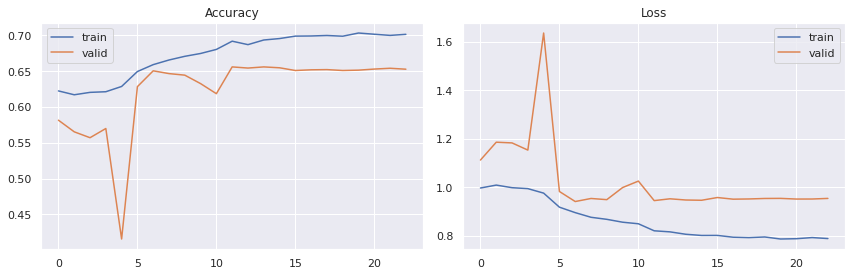

In [51]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_mobilenet.png')
pyplot.show()

In [52]:
label_to_text

{0: 'fear', 1: 'surprise', 2: 'angry', 3: 'happy', 4: 'sad', 5: 'neutral'}

In [53]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'fear': 0, 'surprise': 1, 'angry': 2, 'happy': 3, 'sad': 4, 'neutral': 5}

test accuracy: 65.582 %


              precision    recall  f1-score   support

           0       0.52      0.41      0.46      1536
           1       0.73      0.76      0.75      1201
           2       0.59      0.60      0.60      1486
           3       0.87      0.85      0.86      2697
           4       0.55      0.52      0.54      1823
           5       0.56      0.68      0.61      1859

    accuracy                           0.66     10602
   macro avg       0.64      0.64      0.64     10602
weighted avg       0.66      0.66      0.65     10602



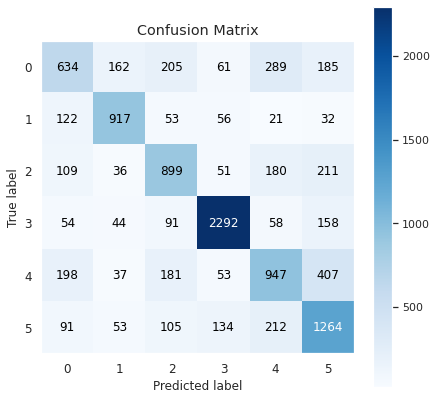

In [62]:
yhat_test = np.argmax(model.predict(X_test), axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig("confusion_matrix_mobilenet.png")

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))

In [56]:
from PIL import Image
from numpy import asarray
# load the image
image_taif_young = Image.open('../input/google-happy-face/Google_happy-face.jpg')

# convert image to numpy array
taifYoung = asarray(image_taif_young)
print(type(taifYoung))
# summarize shape
print(taifYoung.shape)

<class 'numpy.ndarray'>
(422, 360, 3)


In [57]:
taifYoung = cv2.resize(taifYoung,(48,48))

taifYoung = np.reshape(taifYoung,[1,48,48,3])


pred1 = model.predict(taifYoung, verbose=1)
print (pred1)


1/1 [==============================] - 0s 6ms/step
[[0.08384736 0.01596095 0.6079518  0.24469909 0.02527223 0.02226853]]


In [26]:
Eval_pred1 = model.evaluate(taifYoung, verbose=1)
print (Eval_pred1)

1/1 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
[0.0, 0.0]


In [58]:
image_taif_old = Image.open('../input/taif-new-happy/taif_old_happy.jpg')
# convert image to numpy array
taifOld = asarray(image_taif_old)
print(type(taifOld))
# summarize shape
print(taifOld.shape)

<class 'numpy.ndarray'>
(913, 622, 3)


In [59]:
taifOld = cv2.resize(taifOld,(48,48))

taifOld = np.reshape(taifOld,[1,48,48,3])

pred2 = model.predict(taifOld)

print (pred2)

[[0.10765101 0.04331115 0.5029455  0.28269815 0.03038752 0.03300667]]


In [29]:
np.argmax(pred2)

3

In [60]:
image_taif_old = Image.open('../input/google-sad-face/121781993_1097217444009719_7981998709824012270_n.jpg')
# convert image to numpy array
taifOld = asarray(image_taif_old)
print(type(taifOld))
# summarize shape
print(taifOld.shape)

taifOld = cv2.resize(taifOld,(48,48))

taifOld = np.reshape(taifOld,[1,48,48,3])

pred2 = model.predict(taifOld)

print (pred2)

<class 'numpy.ndarray'>
(386, 386, 3)
[[0.08154956 0.02454158 0.6027951  0.20692882 0.04793095 0.03625396]]
